In [29]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
from scipy.special import xlogy

## Forward-Propagation

$$
X \rightarrow Z=W_1X \rightarrow U = W_2Z \rightarrow S=F_{softmax}(U) \rightarrow L(S, y) = -\log S_y,
$$

where $S_y=\frac{\exp(U_y)}{\sum_{j=0}^{K-1}\exp(U_j)}$ is the y-th element of the $S$ and $U_y$ is the y-th element of the $U$.

## Backward-Propagation

$$
\frac{\partial L}{\partial U_t} =  
\begin{cases}
S_t(U), & t\neq y \\
1- S_t(U). & t = y
\end{cases}
\Longrightarrow
\frac{\partial L}{\partial U} = e_y - S(U), 
$$

where $e_y$ is the unit vector, which y-th coordinate equals to 1 and 0 elsewhere. 

\begin{align}
& \frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial U}\frac{\partial U}{\partial W_1} = (e_y - S(U))Z^T \\
& \frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial U}\frac{\partial U}{\partial Z}\frac{\partial Z}{\partial W_1} = \big(\big(e_y - S(U)\big) \cdot W_2\big)X^T
\end{align}

In [19]:
class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layer_sizes=(100), solver='adagrad',
                 batch_size=1, learning_rate=0.001, momentum=0.9, eps=1e-8,
                 max_iter=200, random_state=32, shuffle=True, verbose=False):
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.hidden_layer_sizes = hidden_layer_sizes
        self.momentum = momentum
        self.eps = eps
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.shuffle = shuffle
        self.verbose = verbose

    def __stable_softmax(self, x):
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        return x / x.sum(axis=1, keepdims=True)

    def __crossentropy_loss(self, y_true, y_prob):
        return - xlogy(y_true, y_prob).sum()

    def __forward_layer(self, x, w, activation_function):
        out = np.dot(x, w)
        if activation_function is not None:
            out = activation_function(out)
        return out

    def __forward_propagate(self, x):
        weights = self.weights
        out_activations = [x]
        for weight, activataion in zip(weights, self.functions):
            out = self.__forward_layer(out_activations[-1], weight, activataion)
            out_activations.append(out)
        return out_activations

    def __back_propagation(self, activations, y):
        weights = self.weights
        coef_grads = [np.empty_like(a_layer) for a_layer in weights]

        deltas = activations[-1] - y
        coef_grads[-1] = np.dot(activations[-2].T, deltas)

        for i in range(len(weights)-2, -1, -1):
            deltas =  np.dot(deltas, weights[i + 1].T)
            coef_grads[i] = np.dot(activations[i].T, deltas)

        return coef_grads

    def __init_layer(self, input_size, output_size):
        a = 2.0/(input_size + output_size)
        w = np.random.uniform(-a, a, (input_size, output_size))
        return w

    def fit(self, X, y):
        np.random.seed(self.random_state)

        self._label_binarizer = LabelBinarizer()
        y_train = y
        X_train = X
        y = self._label_binarizer.fit_transform(y)
        self._num_classes = len(self._label_binarizer.classes_)

        n, p = X.shape
        s = self.hidden_layer_sizes[0]

        self.weights = [
            self.__init_layer(p, s),
            self.__init_layer(s, self._num_classes)
        ]

        self.functions = [
            None,
            self.__stable_softmax,
        ]

        accum_grad = [np.zeros_like(param) for param in self.weights]

        for j in range(self.max_iter):
            accumulated_loss = 0.0

            if self.shuffle:
                indices = np.arange(n)
                np.random.shuffle(indices)
                X = X.take(indices, axis=0)
                y = y.take(indices, axis=0)
            
            for i in range(0, n, self.batch_size):
                X_batch = X[i : i + self.batch_size]
                y_batch = y[i : i + self.batch_size]

                activations = self.__forward_propagate(X_batch)

                y_prob = activations[-1]

                accumulated_loss += self.__crossentropy_loss(y_batch, y_prob)
                coef_grads = self.__back_propagation(activations, y_batch)

                coef_grads = [grad / self.batch_size for grad in coef_grads]
                accum_grad = [accum + grad**2 for accum, grad in zip(accum_grad, coef_grads)]
                inv_accum_grad = [self.learning_rate / np.sqrt(self.eps + accum) for accum in accum_grad]
                self.weights = [weight - inv_accum * grad for weight, inv_accum, grad in zip(self.weights, inv_accum_grad, coef_grads)]

            if self.verbose:
                loss = accumulated_loss / X.shape[0]
                y_pred = self.predict(X_train)
                accuracy = (y_pred == y_train).mean()
                print("Epoch {}/{};\t Train accuracy: {:.3f} \t Loss : {:.3f}".format(j + 1, self.max_iter, accuracy, loss))

        return self

    def predict(self, X):
        activations = self.__forward_propagate(X)
        y_pred = activations[-1]
        return self._label_binarizer.inverse_transform(y_pred)

## Read datasets

In [9]:
from sklearn.datasets import fetch_mldata

data_train = pd.read_csv("../dataset/mldata/mnist_train.csv", header=None)
data_test = pd.read_csv("../dataset/mldata/mnist_test.csv", header=None)

x_train = np.ascontiguousarray(data_train[data_train.columns[:-1]].values, dtype=np.float32)
y_train = np.ascontiguousarray(data_train[data_train.columns[-1]].values, dtype=np.float32)
x_test = np.ascontiguousarray(data_test[data_test.columns[:-1]].values, dtype=np.float32)
y_test = np.ascontiguousarray(data_test[data_test.columns[-1]].values, dtype=np.float32)

print('train size: ', x_train.shape, y_train.shape)
print('test size: ', x_test.shape, y_test.shape)

train size:  (60000, 784) (60000,)
test size:  (10000, 784) (10000,)


## Normalize datasets

In [10]:
x_train /= 255
x_test /= 255

## Grid search parameters for Neural Network

In [11]:
from sklearn.model_selection import GridSearchCV

In [48]:
parameters = {
    'hidden_layer_sizes': [(16,), (32,), (48,), (64,), (76,), (92,)],
}

estimator = DNNClassifier(solver='adagrad',
     batch_size=256, learning_rate=0.05, max_iter=50,
     random_state=777, verbose=False)

clf = GridSearchCV(estimator, parameters, cv=5, scoring='accuracy')
clf.fit(x_train, y_train)
print("Лучший подбор параметра для DNNClassifier: {}".format(clf.best_params_))
print("Лучший scope для DNNClassifier: {}".format(clf.best_score_))

Лучший подбор параметра для DNNClassifier: {'hidden_layer_sizes': (16,)}
Лучший scope для DNNClassifier: 0.922


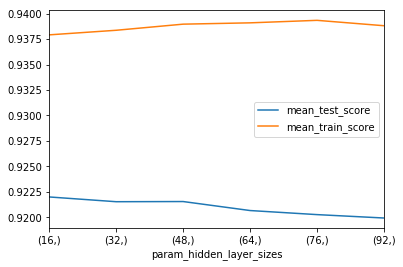

In [49]:
pd.DataFrame(clf.cv_results_).plot(x='param_hidden_layer_sizes', y=[ 'mean_test_score', 'mean_train_score'])

In [44]:
best_estimator = clf.best_estimator_
up_params = {'verbose': True, 'max_iter': 30}
best_estimator.set_params(**up_params)
best_estimator

DNNClassifier(batch_size=256, eps=1e-08, hidden_layer_sizes=(16,),
       learning_rate=0.05, max_iter=30, momentum=0.9, random_state=777,
       shuffle=True, solver=None, verbose=True)

In [45]:
%%time
best_estimator.fit(x_train, y_train)

Epoch 1/30;	 Train accuracy: 0.917 	 Loss : 0.405
Epoch 2/30;	 Train accuracy: 0.922 	 Loss : 0.293
Epoch 3/30;	 Train accuracy: 0.924 	 Loss : 0.279
Epoch 4/30;	 Train accuracy: 0.927 	 Loss : 0.272
Epoch 5/30;	 Train accuracy: 0.928 	 Loss : 0.268
Epoch 6/30;	 Train accuracy: 0.930 	 Loss : 0.264
Epoch 7/30;	 Train accuracy: 0.929 	 Loss : 0.262
Epoch 8/30;	 Train accuracy: 0.930 	 Loss : 0.260
Epoch 9/30;	 Train accuracy: 0.931 	 Loss : 0.258
Epoch 10/30;	 Train accuracy: 0.929 	 Loss : 0.257
Epoch 11/30;	 Train accuracy: 0.932 	 Loss : 0.255
Epoch 12/30;	 Train accuracy: 0.932 	 Loss : 0.254
Epoch 13/30;	 Train accuracy: 0.932 	 Loss : 0.253
Epoch 14/30;	 Train accuracy: 0.933 	 Loss : 0.252
Epoch 15/30;	 Train accuracy: 0.932 	 Loss : 0.251
Epoch 16/30;	 Train accuracy: 0.933 	 Loss : 0.250
Epoch 17/30;	 Train accuracy: 0.933 	 Loss : 0.249
Epoch 18/30;	 Train accuracy: 0.934 	 Loss : 0.249
Epoch 19/30;	 Train accuracy: 0.933 	 Loss : 0.248
Epoch 20/30;	 Train accuracy: 0.934 	 Lo

DNNClassifier(batch_size=256, eps=1e-08, hidden_layer_sizes=(16,),
       learning_rate=0.05, max_iter=30, momentum=0.9, random_state=777,
       shuffle=True, solver=None, verbose=True)

## Accuracy for testing datasets

In [46]:
y_pred = best_estimator.predict(x_test)
print((y_pred == y_test).mean())

0.9259


## Versus the sklearn MLP

In [55]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(16,), max_iter=30, alpha=0, activation='identity',
                     batch_size=256, solver='adam', verbose=10, random_state=777,
                     tol=0, shuffle=True)
clf.fit(x_train, y_train)

Iteration 1, loss = 0.73436694
Iteration 2, loss = 0.35062043
Iteration 3, loss = 0.30739383
Iteration 4, loss = 0.28902413
Iteration 5, loss = 0.27904313
Iteration 6, loss = 0.27252593
Iteration 7, loss = 0.26722828
Iteration 8, loss = 0.26373192
Iteration 9, loss = 0.26013310
Iteration 10, loss = 0.25787084
Iteration 11, loss = 0.25518767
Iteration 12, loss = 0.25345777
Iteration 13, loss = 0.25129781
Iteration 14, loss = 0.25017786
Iteration 15, loss = 0.24874089
Iteration 16, loss = 0.24708613
Iteration 17, loss = 0.24613000
Iteration 18, loss = 0.24500568
Iteration 19, loss = 0.24473631
Iteration 20, loss = 0.24350242
Iteration 21, loss = 0.24221757
Iteration 22, loss = 0.24145957
Iteration 23, loss = 0.24186943
Iteration 24, loss = 0.24089721
Iteration 25, loss = 0.23973297
Iteration 26, loss = 0.23929363
Iteration 27, loss = 0.23851964
Iteration 28, loss = 0.23824422
Iteration 29, loss = 0.23767271
Iteration 30, loss = 0.23757961


MLPClassifier(activation='identity', alpha=0, batch_size=256, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(16,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=30, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=777,
       shuffle=True, solver='adam', tol=0, validation_fraction=0.1,
       verbose=10, warm_start=False)

In [56]:
y_pred = clf.predict(x_test)
print((y_pred == y_test).mean())

0.9267
